# Sprint ディープラーニングフレームワーク1

### 【問題1】スクラッチを振り返る

・重みを初期化する必要があった  
・バイアスの初期化が必要  
・エポックのループが必要だった  
・訓練データのバッチ化が必要  
・フォアードプロパゲーションが必要  
・交差エントロピー誤差の算出が必要  
・バックプロパゲーションが必要、重み、バイアスの更新が必要  
  
・予測が必要、テストデータのシェイプに注意する  
  




### 【問題2】スクラッチとTensorFlowの対応を考える

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import StandardScaler

In [2]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path = "Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor") |
        (df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm",
               "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y == 'Iris-versicolor'] = 0
y[y == 'Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """

    def __init__(self, X, y, batch_size=10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# ----------------------------------------------------------------------------------------------------------
# 単純な3層ニューラルネットワーク
# ----------------------------------------------------------------------------------------------------------


def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    # 重みとバイアスの初期化
    # ３層あるので、3つずつ
    # tf.random_normal([m, n])でランダムな値のm行n列の配列
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    # layer_1に
    # tf.add()で以下を加算したものを代入する
    # tf.matmul(x, weights['w1'])= X@w1
    # biases['b1']= bias
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    # layer_1に対して、Relu関数を適用する→ニューロンを活性化する
    layer_1 = tf.nn.relu(layer_1)

    # layer_2に
    # layer_1の結果を引数として、layer_1と同様に代入する
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # layer_outputは出力層
    # layer_2と同様であるが、活性化関数は適用しない
    layer_output = tf.matmul(
        layer_2, weights['w3']) + biases['b3']  # tf.addと+は等価である

    return layer_output


# ネットワーク構造の読み込み
# Xを引数としているが、まだ計算はされていない
logits = example_net(X)

# 目的関数
# エントロピー誤差の平均を求める
# tf.reduce_mean()で平均を求める
# tf.nn.sigmoid_cross_entropy_with_logits()でcross entorpyを求める
# labels=Yが正解ラベル、logits=logitsが予測値
loss_op = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# 最適化手法
# AdamOptimizerは初期学習率を用いないのがポイント
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# パラメータの更新
train_op = optimizer.minimize(loss_op)

# 推定結果
# シグナム関数を用いる
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
# メモリの確保
init = tf.global_variables_initializer()


# 計算グラフの実行
# セッションを確立
with tf.Session() as sess:
    # tf.global_variables_initializer()の実行
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        # np.ceilで小数点以下切り上げ
        # astype(np.int)でint型にする
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                                 X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        # エポックごとのlossの平均を出す
        # ミニバッチの数で割る
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run(
            [loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(
            epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Instructions for updating:
Colocations handled automatically by placer.
Epoch 0, loss : 27.6129, val_loss : 38.4240, acc : 0.500, val_acc : 0.375
Epoch 1, loss : 40.8195, val_loss : 10.8812, acc : 0.500, val_acc : 0.688
Epoch 2, loss : 7.5137, val_loss : 8.1339, acc : 0.500, val_acc : 0.625
Epoch 3, loss : 8.0101, val_loss : 2.5854, acc : 0.500, val_acc : 0.625
Epoch 4, loss : 9.6315, val_loss : 3.9951, acc : 0.500, val_acc : 0.812
Epoch 5, loss : 0.4968, val_loss : 2.7179, acc : 0.750, val_acc : 0.750
Epoch 6, loss : 3.3309, val_loss : 3.4557, acc : 0.500, val_acc : 0.812
Epoch 7, loss : 0.0003, val_loss : 1.6771, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0000, val_loss : 0.2850, acc : 1.000, val_acc : 0.875
Epoch 9, loss : 0.0031, val_loss : 2.8886, acc : 1.000, val_acc : 0.812
test_acc : 0.800


### 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

In [3]:
# データセットの読み込み
dataset_path = "Iris.csv"
df = pd.read_csv(dataset_path)

In [4]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,0.2,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [5]:
# データセットの読み込み
dataset_path = "Iris.csv"
df = pd.read_csv(dataset_path)
# ３種全てなのでデータフレームから条件抽出しない

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm",
               "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y).reshape((-1, 1))
X = np.array(X)
# ラベルをone-hot encording
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories="auto", sparse=False, dtype=np.int)
y = enc.fit_transform(y)

#y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

In [6]:
#正解ラベルの確認
print(y[[0, 50, 100]])

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [7]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# ----------------------------------------------------------------------------------------------------------
# 単純な3層ニューラルネットワーク
# ----------------------------------------------------------------------------------------------------------


def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    # 重みとバイアスの初期化
    # ３層あるので、3つずつ
    # tf.random_normal([m, n])でランダムな値のm行n列の配列
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    # layer_1に
    # tf.add()で以下を加算したものを代入する
    # tf.matmul(x, weights['w1'])= X@w1
    # biases['b1']= bias
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    # layer_1に対して、Relu関数を適用する→ニューロンを活性化する
    layer_1 = tf.nn.relu(layer_1)

    # layer_2に
    # layer_1の結果を引数として、layer_1と同様に代入する
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # layer_outputは出力層
    # layer_2と同様であるが、活性化関数は適用しない
    layer_output = tf.matmul(
        layer_2, weights['w3']) + biases['b3']  # tf.addと+は等価である

    return layer_output


# ネットワーク構造の読み込み
# Xを引数としているが、まだ計算はされていない
logits = example_net(X)
model = tf.nn.softmax(logits)

# 目的関数
# エントロピー誤差の平均を求める
# tf.reduce_mean()で平均を求める
# tf.nn.sigmoid_cross_entropy_with_logits()でcross entorpyを求める
# labels=Yが正解ラベル、logits=logitsが予測値
loss_op =  tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
#-tf.reduce_sum(Y * tf.log(model))

# 最適化手法
# AdamOptimizerは2018年10月１日時点では
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# パラメータの更新
train_op = optimizer.minimize(loss_op)

# 推定結果
# ソフトマックス 関数を用いる
# 最大値のcolumnを算出する
correct_pred = tf.equal(tf.argmax(Y, axis=1) , tf.argmax(model, axis=1))
#correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
# セッションを確立
with tf.Session() as sess:
    # tf.global_variables_initializer()の実行
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        # np.ceilで小数点以下切り上げ
        # astype(np.int)でint型にする
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print("mini_batch_x", mini_batch_x)
            #print("mini_batch_y", mini_batch_y)
            #print("logits", sess.run(logits, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("model", sess.run(model, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("loss", sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("correct_pred", sess.run(correct_pred, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("acc", sess.run([loss_op, accuracy], feed_dict={
            #                     X: mini_batch_x, Y: mini_batch_y}))
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                                 X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        # エポックごとの平均を出す
        # ミニバッチの数で割る
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run(
            [loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(
            epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 14.9310, val_loss : 18.6336, acc : 0.833, val_acc : 0.583
Epoch 1, loss : 4.1165, val_loss : 9.4869, acc : 0.667, val_acc : 0.708
Epoch 2, loss : 5.8548, val_loss : 2.6694, acc : 0.833, val_acc : 0.875
Epoch 3, loss : 0.0000, val_loss : 1.8040, acc : 1.000, val_acc : 0.917
Epoch 4, loss : 0.0000, val_loss : 0.6792, acc : 1.000, val_acc : 0.917
Epoch 5, loss : 0.0000, val_loss : 2.3201, acc : 1.000, val_acc : 0.917
Epoch 6, loss : 0.0629, val_loss : 6.8811, acc : 1.000, val_acc : 0.750
Epoch 7, loss : 0.3128, val_loss : 8.1174, acc : 0.833, val_acc : 0.750
Epoch 8, loss : 0.0000, val_loss : 6.3794, acc : 1.000, val_acc : 0.833
Epoch 9, loss : 0.0000, val_loss : 3.6720, acc : 1.000, val_acc : 0.917
test_acc : 0.967


### 【問題4】House Pricesのモデルを作成

In [8]:
# データセットの読み込み
dataset_path = "train.csv"
df = pd.read_csv(dataset_path)
# ３種全てなのでデータフレームから条件抽出しない

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y).reshape((-1, 1))
X = np.array(X)

#対数変換
y = np.log10(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
# 標準化
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
y

array([[5.31910606],
       [5.25887663],
       [5.34927753],
       ...,
       [5.42569721],
       [5.15267048],
       [5.16879202]])

In [10]:
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 400
num_epochs = 200

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# ----------------------------------------------------------------------------------------------------------
# 単純な3層ニューラルネットワーク
# ----------------------------------------------------------------------------------------------------------


def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    # 重みとバイアスの初期化
    # ３層あるので、3つずつ
    # tf.random_normal([m, n])でランダムな値のm行n列の配列
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    # layer_1に
    # tf.add()で以下を加算したものを代入する
    # tf.matmul(x, weights['w1'])= X@w1
    # biases['b1']= bias
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    # layer_1に対して、Relu関数を適用する→ニューロンを活性化する
    layer_1 = tf.nn.relu(layer_1)

    # layer_2に
    # layer_1の結果を引数として、layer_1と同様に代入する
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # layer_outputは出力層
    # layer_2と同様であるが、活性化関数は適用しない
    layer_output = tf.matmul(
        layer_2, weights['w3']) + biases['b3']  # tf.addと+は等価である

    return layer_output


# ネットワーク構造の読み込み
# Xを引数としているが、まだ計算はされていない
logits = example_net(X)


# 目的関数
# 平均二乗誤差を求める
loss_op =  tf.reduce_sum(tf.square(Y - logits))

# 最適化手法
# AdamOptimizerは2018年10月１日時点では
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# パラメータの更新
train_op = optimizer.minimize(loss_op)

# 推定結果
#correct_pred = tf.equal(tf.argmax(Y, axis=1) , tf.argmax(model, axis=1))
#correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
mean_squared_error = tf.losses.mean_squared_error(Y ,logits)

# variableの初期化
init = tf.global_variables_initializer()

# 記録用’
loss_array = np.zeros(num_epochs)
val_loss_array = np.zeros(num_epochs)
mse_array = np.zeros(num_epochs)
val_mse_array = np.zeros(num_epochs)

# 計算グラフの実行
# セッションを確立
with tf.Session() as sess:
    # tf.global_variables_initializer()の実行
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        # np.ceilで小数点以下切り上げ
        # astype(np.int)でint型にする
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_mse = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #print("mini_batch_x", mini_batch_x)
            #print("mini_batch_y", mini_batch_y)
            #print("logits", sess.run(logits, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("model", sess.run(model, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("loss", sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("correct_pred", sess.run(correct_pred, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("acc", sess.run([loss_op, accuracy], feed_dict={
            #                     X: mini_batch_x, Y: mini_batch_y}))
            loss, mse = sess.run([loss_op, mean_squared_error], feed_dict={
                                 X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_mse += mse
        # エポックごとの平均を出す
        # ミニバッチの数で割る
        total_loss /= n_samples
        total_mse /= n_samples
        val_loss, val_mse = sess.run(
            [loss_op, mean_squared_error], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, mse : {:.3f}, val_mse : {:.3f}".format(
            epoch, loss, val_loss, mse, val_mse))
        loss_array[epoch] = loss
        val_loss_array[epoch] = val_loss
        mse_array[epoch] = mse
        val_mse_array[epoch] = val_mse
    test_mse = sess.run(mean_squared_error, feed_dict={X: X_test, Y: y_test})
    print("test_mse : {:.3f}".format(test_mse))
    

Instructions for updating:
Use tf.cast instead.
Epoch 0, loss : 100211.1641, val_loss : 1395523584000.0000, mse : 747.844, val_mse : 5963776000.000
Epoch 1, loss : 70460.3516, val_loss : 1162249764864.0000, mse : 525.824, val_mse : 4966879232.000
Epoch 2, loss : 47354.8438, val_loss : 958417928192.0000, mse : 353.394, val_mse : 4095803136.000
Epoch 3, loss : 30364.3438, val_loss : 783883567104.0000, mse : 226.600, val_mse : 3349929728.000
Epoch 4, loss : 18736.0215, val_loss : 638158766080.0000, mse : 139.821, val_mse : 2727174144.000
Epoch 5, loss : 11472.2910, val_loss : 519785021440.0000, mse : 85.614, val_mse : 2221303552.000
Epoch 6, loss : 7439.9517, val_loss : 426105733120.0000, mse : 55.522, val_mse : 1820964608.000
Epoch 7, loss : 5531.8931, val_loss : 354914271232.0000, mse : 41.283, val_mse : 1516727680.000
Epoch 8, loss : 4785.6724, val_loss : 303453569024.0000, mse : 35.714, val_mse : 1296810112.000
Epoch 9, loss : 4503.2876, val_loss : 268317179904.0000, mse : 33.607, val

Epoch 87, loss : 498.0904, val_loss : 165854347264.0000, mse : 3.717, val_mse : 708779264.000
Epoch 88, loss : 489.1747, val_loss : 164300718080.0000, mse : 3.651, val_mse : 702139840.000
Epoch 89, loss : 480.5525, val_loss : 162770649088.0000, mse : 3.586, val_mse : 695601088.000
Epoch 90, loss : 472.1738, val_loss : 161267990528.0000, mse : 3.524, val_mse : 689179456.000
Epoch 91, loss : 464.1376, val_loss : 159790546944.0000, mse : 3.464, val_mse : 682865600.000
Epoch 92, loss : 456.3549, val_loss : 158341234688.0000, mse : 3.406, val_mse : 676671936.000
Epoch 93, loss : 448.7802, val_loss : 156922806272.0000, mse : 3.349, val_mse : 670610304.000
Epoch 94, loss : 441.3427, val_loss : 155535802368.0000, mse : 3.294, val_mse : 664682944.000
Epoch 95, loss : 434.1574, val_loss : 154175291392.0000, mse : 3.240, val_mse : 658868736.000
Epoch 96, loss : 427.1438, val_loss : 152839225344.0000, mse : 3.188, val_mse : 653159104.000
Epoch 97, loss : 420.2861, val_loss : 151528570880.0000, mse

Epoch 199, loss : 162.8703, val_loss : 76398641152.0000, mse : 1.215, val_mse : 326489920.000
test_mse : 1.827


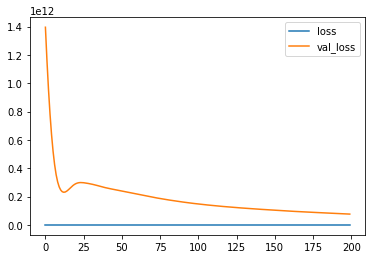

In [11]:
plt.plot(loss_array, label="loss")
plt.plot(val_loss_array, label="val_loss")
plt.legend()
plt.show()

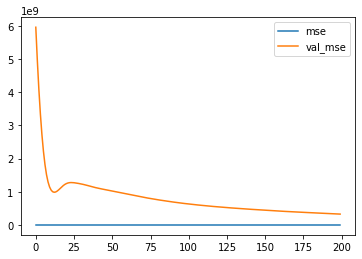

In [12]:
plt.plot(mse_array, label="mse")
plt.plot(val_mse_array, label="val_mse")
plt.legend()
plt.show()

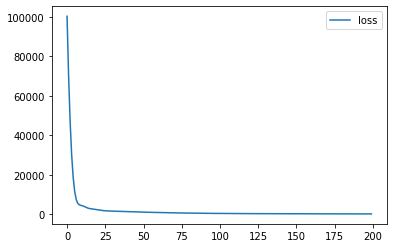

In [13]:
plt.plot(loss_array, label="loss")
plt.legend()
plt.show()

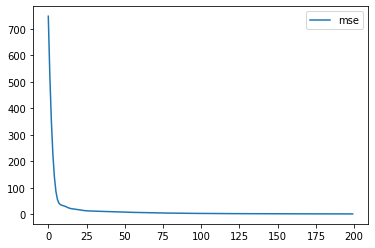

In [14]:
plt.plot(mse_array, label="mse")
plt.legend()
plt.show()

### 【問題5】MNISTのモデルを作成

In [15]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [16]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [17]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [18]:
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 30

n_hidden1 = 400
n_hidden2 = 200
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# ----------------------------------------------------------------------------------------------------------
# 単純な3層ニューラルネットワーク
# ----------------------------------------------------------------------------------------------------------


def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    # 重みとバイアスの初期化
    # ３層あるので、3つずつ
    # tf.random_normal([m, n])でランダムな値のm行n列の配列
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    # layer_1に
    # tf.add()で以下を加算したものを代入する
    # tf.matmul(x, weights['w1'])= X@w1
    # biases['b1']= bias
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    # layer_1に対して、Relu関数を適用する→ニューロンを活性化する
    layer_1 = tf.nn.relu(layer_1)

    # layer_2に
    # layer_1の結果を引数として、layer_1と同様に代入する
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # layer_outputは出力層
    # layer_2と同様であるが、活性化関数は適用しない
    layer_output = tf.matmul(
        layer_2, weights['w3']) + biases['b3']  # tf.addと+は等価である

    return layer_output


# ネットワーク構造の読み込み
# Xを引数としているが、まだ計算はされていない
logits = example_net(X)
model = tf.nn.softmax(logits)

# 目的関数
# エントロピー誤差の平均を求める
# tf.reduce_mean()で平均を求める
# tf.nn.sigmoid_cross_entropy_with_logits()でcross entorpyを求める
# labels=Yが正解ラベル、logits=logitsが予測値
loss_op =  tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
#-tf.reduce_sum(Y * tf.log(model))

# 最適化手法
# AdamOptimizerは2018年10月１日時点では
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# パラメータの更新
train_op = optimizer.minimize(loss_op)

# 推定結果
# ソフトマックス 関数を用いる
# 最大値のcolumnを算出する
correct_pred = tf.equal(tf.argmax(Y, axis=1) , tf.argmax(model, axis=1))
#correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 記録用’
loss_array = np.zeros(num_epochs)
val_loss_array = np.zeros(num_epochs)
acc_array = np.zeros(num_epochs)
val_acc_array = np.zeros(num_epochs)

# 計算グラフの実行
# セッションを確立
with tf.Session() as sess:
    # tf.global_variables_initializer()の実行
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        # np.ceilで小数点以下切り上げ
        # astype(np.int)でint型にする
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            #print("mini_batch_x", mini_batch_x)
            #print("mini_batch_y", mini_batch_y)
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            
            #print("logits", sess.run(logits, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("model", sess.run(model, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("loss", sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("correct_pred", sess.run(correct_pred, feed_dict={X: mini_batch_x, Y: mini_batch_y}))
            #print("acc", sess.run([loss_op, accuracy], feed_dict={
            #                     X: mini_batch_x, Y: mini_batch_y}))
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                                 X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        # エポックごとの平均を出す
        # ミニバッチの数で割る
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run(
            [loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(
            epoch, loss, val_loss, acc, val_acc))
        loss_array[epoch] = loss
        val_loss_array[epoch] = val_loss
        acc_array[epoch] = acc
        val_acc_array[epoch] = val_acc
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 6.8393, val_loss : 27.7098, acc : 0.900, val_acc : 0.907
Epoch 1, loss : 0.0000, val_loss : 17.2411, acc : 1.000, val_acc : 0.930
Epoch 2, loss : 0.0000, val_loss : 14.1634, acc : 1.000, val_acc : 0.938
Epoch 3, loss : 5.1567, val_loss : 12.0293, acc : 0.900, val_acc : 0.947
Epoch 4, loss : 6.6409, val_loss : 12.6909, acc : 0.900, val_acc : 0.945
Epoch 5, loss : 0.0000, val_loss : 10.6165, acc : 1.000, val_acc : 0.953
Epoch 6, loss : 0.0000, val_loss : 10.8366, acc : 1.000, val_acc : 0.955
Epoch 7, loss : 0.0000, val_loss : 10.6702, acc : 1.000, val_acc : 0.955
Epoch 8, loss : 0.0000, val_loss : 11.1066, acc : 1.000, val_acc : 0.956
Epoch 9, loss : 0.0000, val_loss : 9.7764, acc : 1.000, val_acc : 0.960
Epoch 10, loss : 0.0000, val_loss : 10.1980, acc : 1.000, val_acc : 0.961
Epoch 11, loss : 0.0000, val_loss : 10.1221, acc : 1.000, val_acc : 0.961
Epoch 12, loss : 0.0000, val_loss : 9.9451, acc : 1.000, val_acc : 0.962
Epoch 13, loss : 0.0000, val_loss : 10.1161, acc :

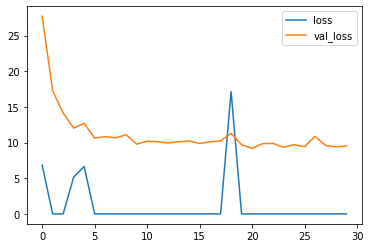

In [19]:
plt.plot(loss_array, label="loss")
plt.plot(val_loss_array, label="val_loss")
plt.legend()
plt.show()

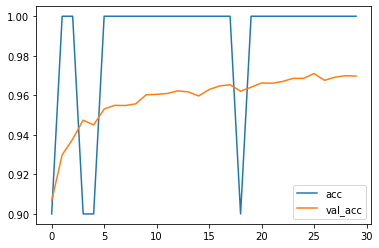

In [20]:
plt.plot(acc_array, label="acc")
plt.plot(val_acc_array, label="val_acc")
plt.legend()
plt.show()